<a href="https://colab.research.google.com/github/hugo-degrossi/cesi_data_science/blob/main/livrable_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Livrable 3

Groupe 2 - Maxime BAILLY-SALINS, Naomie ALBERT, Hugo DE GROSSI, Félix DUFAY


Objective : Generate caption on image.

Dataset : MS-COCO

## Import & Var

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
import zipfile

from PIL import Image
from tqdm import tqdm  # progress bar
from datetime import datetime

In [2]:
print(tf.test.gpu_device_name())  # check if we have gpu

/device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
IMAGE_ZIP = "/content/drive/MyDrive/datasets/livrable_3/train2014.zip"
IMAGE_TARGET_UNZIP = "/content/drive/MyDrive/datasets/livrable_3/train2014/"  # extract folder

ANNOTATION_FILE = "/content/drive/MyDrive/datasets/livrable_3/annotations/captions_train2014.json"
IMAGE_FOLDER = IMAGE_TARGET_UNZIP

# CACHE_FOLDER = "/content/drive/MyDrive/Dataset/train2014_cache_13k/"  # in drive
CACHE_FOLDER = "/content/sample_data/"  # VM -> faster

CHECKPOINT_PATH = "/content/drive/MyDrive/datasets/livrable_3/checkpoint/"  # in drive
# CHECKPOINT_PATH = "/content/sample_data/checkpoint/"  # VM
CHECKPOINT_EPOCH = 5  # save every x epochs

LIMIT_SIZE = 13000 

MAX_LENGTH = 50  # max word count for a caption
VOCABULARY_SIZE = 5000  # use the top x words for a vocabulary

## Extract

In [5]:
# Extract images
# if len([name for name in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, name)) and name.endswith(".jpg")]) < LIMIT_SIZE:
#   archive = zipfile.ZipFile(IMAGE_ZIP, 'r')
#   archive.extractall(IMAGE_TARGET_UNZIP)

## Create a dictionnary containing the caption + Limit train size

In [6]:
with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)

#### Create a dictionnary containing the different caption for an image path.
__Example__ : dict = {image1: [caption1, caption2, caption3, caption4, caption5]
                image2: [caption1, caption2, caption3...]}

In [7]:
image_path_to_caption = collections.defaultdict(list)  # dict with image path -> [caption1, caption2...]
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = IMAGE_FOLDER + 'train2014/COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  if os.path.exists(image_path):  # Delete annotations for images we don't have (as we imported only 13k)
    image_path_to_caption[image_path].append(caption)

### Limit train size

In [8]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:LIMIT_SIZE]  # keep only the first x image_paths from the shuffled set
print(len(train_image_paths))

13000


In [9]:
train_captions = []  # all captions
img_name_vector = []  # all image path

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A bus parked next to a but stop loading area. <end>


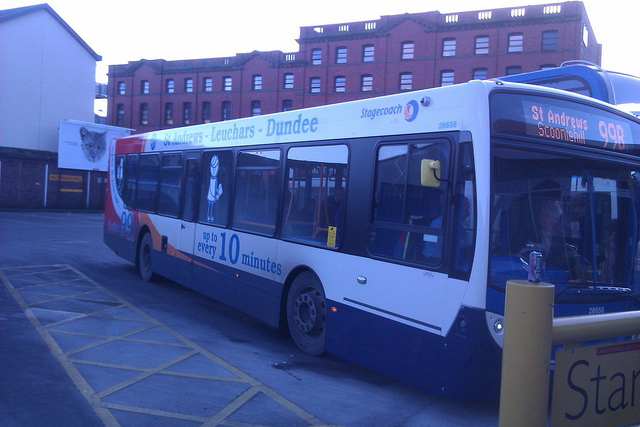

In [11]:
print(train_captions[0])
Image.open(img_name_vector[0])

## InceptionV3

### Prepare image for InceptionV3

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)  # resize 299x299
    img = tf.keras.applications.inception_v3.preprocess_input(img)  # normalize img for InceptionV3
    return img, image_path

### Init InceptionV3 and create image features extractor model

In [13]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                 weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)  # image features extractor model

## Pre-process image and cache on disk

In [14]:
def image_path_to_cache_path(path):
  """ Get cache linked to target image """
  image_name = path.split("/")[-1] + ".npy"
  return os.path.join(CACHE_FOLDER, image_name)

In [15]:
encode_train = sorted(set(img_name_vector))  # get unique images

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)  # get features
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))  # reshape in 2D

  for bf, p in zip(batch_features, path):
    path_of_feature = image_path_to_cache_path(p.numpy().decode("utf-8"))  # get path
    if not os.path.exists(path_of_feature):  #  if not already in cache
      np.save(path_of_feature, bf.numpy())  # save image features

100%|██████████| 813/813 [18:45<00:00,  1.38s/it]


## Tokenize caption

In [16]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Override the default standardization of TextVectorization to preserve
# "<>" characters, so preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_LENGTH)


tokenizer.adapt(caption_dataset)  # learn the vocabulary from the caption dataset

In [17]:
# create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [18]:
# create mapping for words to indices and indicies to words
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

## Split data into train and validation set

In [19]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

# split 80-20
slice_index = int(len(img_keys)*0.8)
img_name_train_keys = img_keys[:slice_index]  # 80% train
img_name_val_keys = img_keys[slice_index:]  # 20% val

# train set
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

# val set
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])
  

In [20]:
# show train/val size
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(52023, 52023, 13006, 13006)

## Create tf.data to train data

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [22]:
# Load the numpy files (cache)
def map_func(img_name, cap):
  img_tensor = np.load(image_path_to_cache_path(img_name.decode('utf-8')))
  return img_tensor, cap

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

### Bahdanau Attention
Full explanation : https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a

In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    # Three dense layers to compute alignement score
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    """ 
    features = CNN_encoder's output (shape -> (batch_size, 64, embedding_dim) )
    hidden = current state from decoder (shape -> (batch_size, hidden_size) ) 
    """

    # hidden_with_time_axis.shape -> (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # This gives you an unnormalized score for each image feature
    score = self.V(attention_hidden_layer)  # calculate alignment score
    # score.shape -> (batch_size, 64, 1)

    
    # apply a softmax activation function to the alignment scores to obtain the attention weights
    attention_weights = tf.nn.softmax(score, axis=1)
     # attention_weights.shape -> (batch_size, 64, 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### Encoder

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    # And convert thoses features into two weights
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder

In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Gated Recurrent Unit
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    """ 
    x : current output of decoder
    features : output of encoder
    hidden : current state of decoder 
    """
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)  # predict next word

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    """ Reset decoder """
    return tf.zeros((batch_size, self.units))

### Create encoder and decoder

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

### Optimizer and loss function

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  """ Calculate loss function """
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Save checkpoints during training

In [29]:
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=5)

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * CHECKPOINT_EPOCH
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Train

In [31]:
loss_plot = []

In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))  # calculate loss

  # calculate gradient and apply to optimizer
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [33]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()  # starting time
    print(f'Epoch {epoch+1} started at {datetime.now()}')
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    loss_plot.append(total_loss / num_steps)  # storing the epoch end loss value to plot later

    if epoch % CHECKPOINT_EPOCH == 0:
      ckpt_manager.save()  # save train progression

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for epoch {epoch+1} : {time.time()-start:.2f} sec\n')

Epoch 1 started at 2022-10-19 16:41:28.010151
Epoch 1 Batch 0 Loss 1.8681
Epoch 1 Batch 100 Loss 1.1431
Epoch 1 Batch 200 Loss 0.9724
Epoch 1 Batch 300 Loss 0.8963
Epoch 1 Batch 400 Loss 0.8034
Epoch 1 Batch 500 Loss 0.8171
Epoch 1 Batch 600 Loss 0.7797
Epoch 1 Batch 700 Loss 0.7193
Epoch 1 Batch 800 Loss 0.7467
Epoch 1 Loss 0.893483
Time taken for epoch 1 : 224.71 sec

Epoch 2 started at 2022-10-19 16:45:12.718152
Epoch 2 Batch 0 Loss 0.7724
Epoch 2 Batch 100 Loss 0.7189
Epoch 2 Batch 200 Loss 0.7809
Epoch 2 Batch 300 Loss 0.6825
Epoch 2 Batch 400 Loss 0.7001
Epoch 2 Batch 500 Loss 0.7792
Epoch 2 Batch 600 Loss 0.6741
Epoch 2 Batch 700 Loss 0.6636
Epoch 2 Batch 800 Loss 0.7371
Epoch 2 Loss 0.703975
Time taken for epoch 2 : 132.15 sec

Epoch 3 started at 2022-10-19 16:47:24.864228
Epoch 3 Batch 0 Loss 0.7703
Epoch 3 Batch 100 Loss 0.6778
Epoch 3 Batch 200 Loss 0.6381
Epoch 3 Batch 300 Loss 0.6379
Epoch 3 Batch 400 Loss 0.6547
Epoch 3 Batch 500 Loss 0.6743
Epoch 3 Batch 600 Loss 0.6271


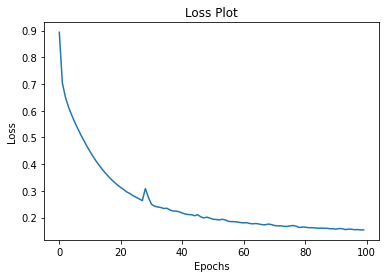

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Validation

### Evaluate Function

In [35]:
def evaluate(image):
    """ Evaluate function """
    attention_plot = np.zeros((MAX_LENGTH, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(MAX_LENGTH):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

### Plot attention Function

In [36]:
def plot_attention(image, result, attention_plot):
    """ Plot attention on image """
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> two people are talking and smiling under colorful umbrellas. <end>
Prediction Caption: an asian girl in a white shirt holding an umbrella <end>


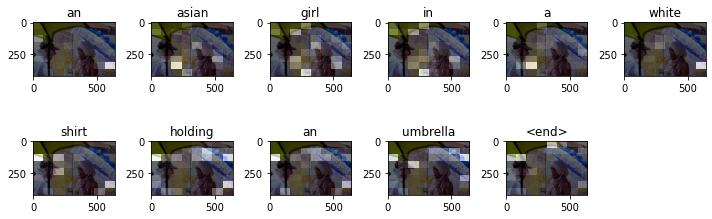

In [37]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try 

64400/64400 [==============================] - 0s 3us/step
Prediction Caption: a man riding a wave on the ocean. <end>


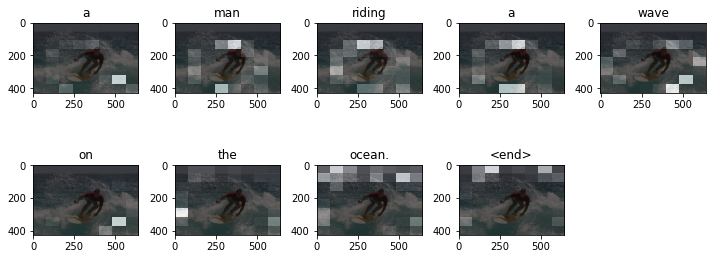

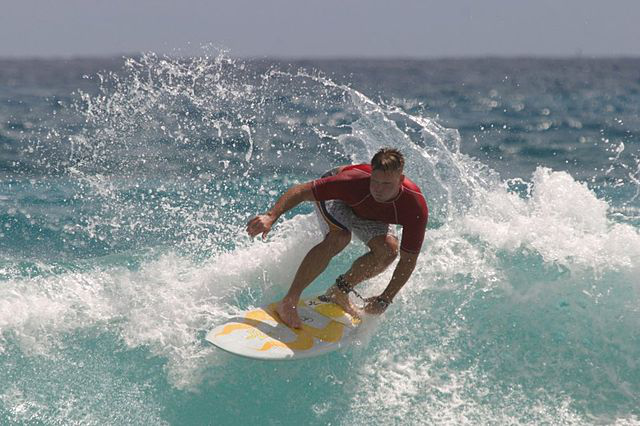

In [38]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)